In [1]:
from __future__ import print_function
import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from siamese import SiameseNetwork
import numpy as np

In [2]:
batch_size = 128
num_classes = 10
epochs = 10

In [3]:
def create_base_model(input_shape):
    model_input = Input(shape=input_shape)

    embedding = Conv2D(64, kernel_size=(4, 4), input_shape=input_shape)(model_input)
    embedding = BatchNormalization()(embedding)
    embedding = Activation(activation='relu')(embedding)
    embedding = MaxPooling2D(pool_size=(2, 2))(embedding)
    
    embedding = Conv2D(128, kernel_size=(3, 3))(embedding)
    embedding = BatchNormalization()(embedding)
    embedding = Activation(activation='relu')(embedding)
    embedding = MaxPooling2D(pool_size=(2, 2))(embedding)
    
    
    embedding = Flatten()(embedding)
    embedding = Dense(256)(embedding)
    embedding = BatchNormalization()(embedding)
    embedding = Activation(activation='sigmoid')(embedding)

    return Model(model_input, embedding)


def create_head_model(embedding_shape):
    embedding_a = Input(shape=embedding_shape[1:])
    embedding_b = Input(shape=embedding_shape[1:])

#     head = Concatenate()([embedding_a, embedding_b])
#     head = Dense(8)(head)
#     head = BatchNormalization()(head)
#     head = Activation(activation='sigmoid')(head)

#     head = Dense(1)(head)
#     head = BatchNormalization()(head)
#     head = Activation(activation='sigmoid')(head)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([embedding_a, embedding_b])
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    return Model([embedding_a, embedding_b], prediction)

## 以下是測試 3 way 5 shot

In [4]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageColor
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [5]:
# 讀入預先選好的訓練資料
folder = 'E:\大學\大四上\機器學習與資訊安全之應用\image'
files = [f for f in listdir(folder) if isfile(join(folder, f))]
print('Amount of the files:', len(files))

Amount of the files: 31


In [6]:
malware_family = pd.read_csv("E:\大學\大四上\機器學習與資訊安全之應用\dataset.csv")
def query_family(filename):
    for idx, fname in enumerate(malware_family['filename']):
        if fname == filename:
            return malware_family['label'][idx]
    return 'file not found!'

C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
all_category_count = []
for idx, file in enumerate(files):
    all_category_count.append(query_family(file[0:-4]))

counter = Counter(all_category_count)
print(len(counter))
counter.most_common(20)

3


[('Unknown', 11), ('Mirai', 10), ('Android', 10)]

In [8]:
folder = "E:\大學\大四上\機器學習與資訊安全之應用\data/"
def making_image(counting_matrix, unit = 16):
    image = np.zeros((unit, unit, 3), dtype=np.uint8)
    for i in range(unit):
        for j in range(unit):
            rgb_value = ImageColor.getcolor(color_mapping(counting_matrix[i][j], i), "RGB")
            image[i][j] = list(rgb_value)
    img = Image.fromarray(image, 'RGB')
#     plt.imshow(img)
#     plt.show()
    return image
def catagory_encode(c):
    all_catagory = ["unistd.h", "uio.h", "stdlib.h", "signal.h", "socket.h", "time.h", "fcntl.h", "prctl.h", "wait.h", "stat.h",
                   "mman.h", "resource.h", "SIG", "syscall.h", "futex.h", "other"]
    for idx, catagory in enumerate(all_catagory):
        if catagory == c:
            return idx
    return -1

def get_syscall_catagory(syscall):
    catagories = []
    if syscall in ["execve", "getpid", "exit_group", "rt_sigprocmask", "close", "brk", "getppid", "write", "fork", "setsid",
                  "read", "getdents64", "readlink", "socketcall", "chdir", "setuid32", "setresuid32", "access", "vfork", 
                  "set_thread_area", "set_tid_address", "mmap2", "getuid32", "getcwd", "unlink", "rmdir", "arch_prctl", 
                   "set_robust_list", "futex", "pipe2", "gettid", "clone", "lseek", "getdents", "geteuid32", "setuid", 
                   "setresuid", "getuid", "dup2", "readlinkat", "geteuid", "fchown", "pipe"]:
        catagories.append("unistd.h")
    if syscall in ["writev", "readv"]:
        catagories.append("uio.h")
    if syscall in ["EXIT", "exit"]:
        catagories.append("stdlib.h")
    if syscall in ["rt_sigprocmask", "rt_sigaction", "kill", "KILL"]:
        catagories.append("signal.h")
    if syscall in ["socket", "connect", "getsockname", "setsockopt", "sendto", "recvfrom", "getsockopt", "recv", "bind", 
                   "listen", "send"]:
        catagories.append("socket.h")
    if syscall in ["time", "nanosleep", "clock_getres", "clock_gettime", "gettimeofday"]:
        catagories.append("time.h")
    if syscall in ["fcntl", "open", "access", "fcntl64", "unlink", "fchown32", "rename", "stat", "openat", "dup2", "oldstat"]:
        catagories.append("fcntl.h")
    if syscall in ["prctl", "arch_prctl"]:
        catagories.append("prctl.h")
    if syscall in ["wait4", "waitpid"]:
        catagories.append("wait.h")
    if syscall in ["fstat", "fstat64", "stat64", "lstat64", "fchmod", "fchown32", "stat", "umask", "lstat", "oldstat", "chmod"]:
        catagories.append("stat.h")
    if syscall in ["mmap2", "mprotect", "munmap", "mmap"]:
        catagories.append("mman.h")
    if syscall in ["getrlimit", "ugetrlimit", "setrlimit"]:
        catagories.append("resource.h")
    if syscall[0:3] == "SIG":
        catagories.append("SIG")
    if syscall in ["exit_group", "rt_sigprocmask", "getdents64", "socketcall", "access", "set_thread_area", "set_tid_address",
                  "mmap2", "arch_prctl", "set_robust_list", "futex", "clone", "getdents"]:
        catagories.append("syscall.h")
    if syscall in ["set_robust_list", "futex"]:
        catagories.append("futex.h")
    if len(catagories) == 0:
        catagories.append("other")
    return catagories

def extract_API_seqence_to_counting_matrix(filename, unit = 16):
    sample = pd.read_csv(folder + filename)
    api_seq = sample[sample.columns[1:3]]
    unit_time = (sample['TIMESTAMP'][len(sample) - 1] - sample['TIMESTAMP'][0]) / unit
    #api_seq['TIMESTAMP'] -= api_seq['TIMESTAMP'][0] # 扣掉起始時間
    #api_seq['TIMESTAMP'] = api_seq['TIMESTAMP'] // unit_time # 看是第幾個 unit 
    #api_seq['TIMESTAMP'] = api_seq['TIMESTAMP'].apply(lambda x: int(unit - 1) if x == unit else int(x)) # 避免超出範圍，同時轉為整數
    api_seq.iloc[:, 0] = api_seq['TIMESTAMP'] - api_seq['TIMESTAMP'][0] # 扣掉起始時間
    api_seq.iloc[:, 0] = api_seq['TIMESTAMP'] // unit_time # 看是第幾個 unit
    api_seq.iloc[:, 0] = api_seq['TIMESTAMP'].apply(lambda x: int(unit - 1) if x == unit else int(x)) # 避免超出範圍，同時轉為整數
    print('unit_time:', unit_time)
    
    api_seq_in_each_period = []
    for i in range(unit):
        api_seq_in_each_period.append([])
    for idx in range(len(api_seq)):
        api_seq_in_each_period[api_seq['TIMESTAMP'][idx]].append(api_seq['SYSCALL'][idx])
        
    counting_catagory_matrix = np.zeros((unit, unit))
    for i in range(unit):
        counter = Counter(api_seq_in_each_period[i])
        for key in counter.keys():
            key_catagory = get_syscall_catagory(key)
            for catagory in key_catagory:
                counting_catagory_matrix[i][catagory_encode(catagory)] += counter[key]
    return counting_catagory_matrix, unit_time
def color_mapping(occurence, category_idx):
    matrix = [
        ["#FFFFFF", "#FFC1E0", "#FFAAD5", "#FF95CA", "#FF79BC", "#FF60AF", "#FF359A", "#FF0080", "#F00078", "#D9006C", "#BF0060"],
        ["#FFFFFF", "#FFBFFF", "#FFA6FF", "#FF8EFF", "#FF77FF", "#FF44FF", "#FF00FF", "#E800E8", "#D200D2", "#AE00AE", "#930093"],
        ["#FFFFFF", "#FFDAC8", "#FFCBB3", "#FFBD9D", "#FFAD86", "#FF9D6F", "#FF8F59", "#FF8040", "#FF5809", "#F75000", "#D94600"],
        ["#FFFFFF", "#D3FF93", "#CCFF80", "#B7FF4A", "#A8FF24", "#9AFF02", "#8CEA00", "#82D900", "#73BF00", "#64A600", "#548C00"],
        ["#FFFFFF", "#CAFFFF", "#BBFFFF", "#A6FFFF", "#4DFFFF", "#00FFFF", "#00E3E3", "#00CACA", "#00AEAE", "#009393", "#005757"],
        ["#FFFFFF", "#C1FFE4", "#ADFEDC", "#96FED1", "#4EFEB3", "#1AFD9C", "#02F78E", "#02DF82", "#01B468", "#019858", "#01814A"],
        ["#FFFFFF", "#D6D6AD", "#CDCD9A", "#C2C287", "#B9B973", "#AFAF61", "#A5A552", "#949449", "#808040", "#707038", "#616130"],
        ["#FFFFFF", "#DCB5FF", "#D3A4FF", "#CA8EFF", "#BE77FF", "#B15BFF", "#9F35FF", "#921AFF", "#8600FF", "#6E00FF", "#5B00AE"],
        ["#FFFFFF", "#FFFF6F", "#FFFF37", "#F9F900", "#E1E100", "#C4C400", "#A6A600", "#8C8C00", "#737300", "#5B5B00", "#5B5B00"],
        ["#FFFFFF", "#FFE66F", "#FFE153", "#FFDC35", "#FFD306", "#EAC100", "#D9B300", "#C6A300", "#AE8F00", "#977C00", "#796400"],
        ["#FFFFFF", "#D8D8EB", "#C7C7E2", "#B8B8DC", "#A6A6D2", "#9999CC", "#8080C0", "#7373B9", "#5A5AAD", "#5151A2", "#484891"],
        ["#FFFFFF", "#97CBFF", "#84C1FF", "#66B3FF", "#46A3FF", "#2894FF", "#0080FF", "#0072E3", "#0066CC", "#005AB5", "#004B97"],
        ["#FFFFFF", "#B9B9FF", "#AAAAFF", "#9393FF", "#7D7DFF", "#6A6AFF", "#4A4AFF", "#2828FF", "#0000E3", "#0000C6", "#0000C6"],
        ["#FFFFFF", "#FFD1A4", "#FFC78E", "#FFBB77", "#FFAF60", "#FFA042", "#FF9224", "#FF8000", "#EA7500", "#D26900", "#BB5E00"],
        ["#FFFFFF", "#FF9797", "#FF7575", "#FF5151", "#FF2D2D", "#FF0000", "#EA0000", "#CE0000", "#AE0000", "#930000", "#750000"],
        ["#FFFFFF", "#93FF93", "#79FF79", "#53FF53", "#28FF28", "#00EC00", "#00DB00", "#00BB00", "#00A600", "#009100", "#007500"]
    ]
    if occurence == 0:
        idx = 0
    elif occurence < 3:
        idx = 1
    elif occurence < 7:
        idx = 2
    elif occurence < 12:
        idx = 3
    elif occurence < 18:
        idx = 4
    elif occurence < 25:
        idx = 5
    elif occurence < 33:
        idx = 6
    elif occurence < 42:
        idx = 7
    elif occurence < 100:
        idx = 8
    elif occurence < 200:
        idx = 9
    else :
        idx = 10
    return matrix[category_idx][idx]

C:\Users\cherry\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


unit_time: 7.515083879232407
Mirai


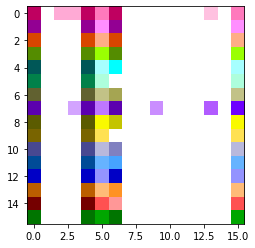

unit_time: 7.345082998275757
Mirai


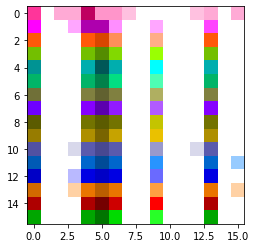

C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (3,6,8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


unit_time: 7.523230314254761
Mirai


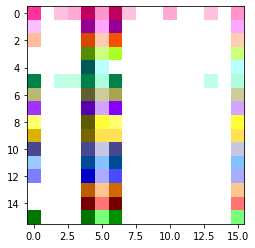

unit_time: 7.468452870845795
Mirai


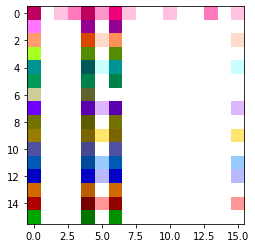

unit_time: 7.577550932765007
Mirai


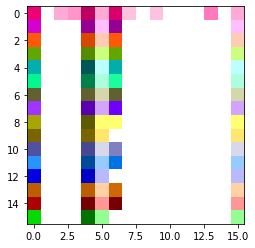

unit_time: 7.533068507909775
Mirai


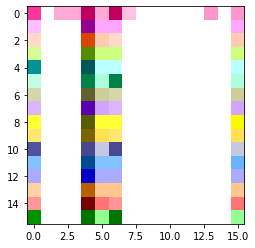

C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


unit_time: 7.648858368396759
Unknown


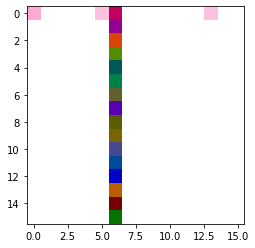

C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


unit_time: 7.5880448669195175
Mirai


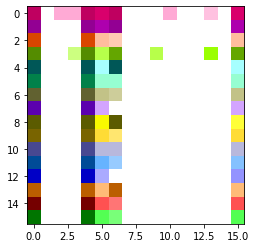

unit_time: 7.617846995592117
Unknown


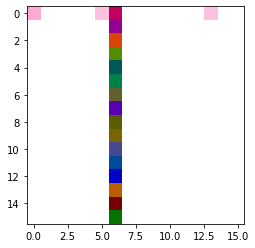

unit_time: 7.645029813051224
Mirai


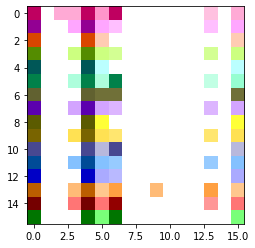

unit_time: 7.660736441612244
Mirai


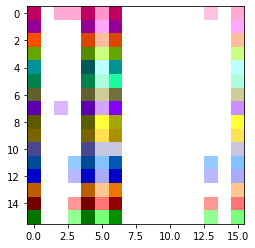

unit_time: 7.013750001788139
Mirai


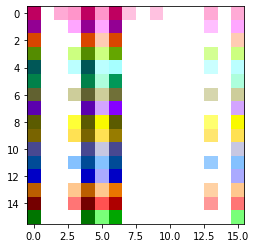

unit_time: 0.007379636168479919
Android


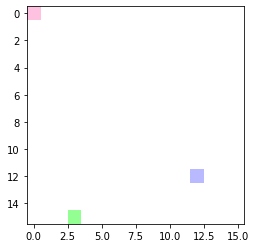

unit_time: 7.530603751540184
Unknown


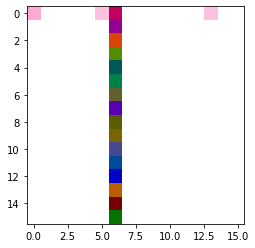

unit_time: 7.680353119969368
Unknown


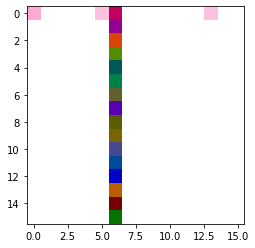

unit_time: 7.58690869808197
Unknown


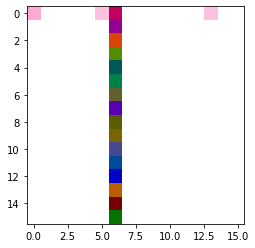

unit_time: 0.0007838159799575806
Android


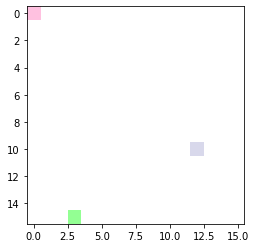

unit_time: 7.598620802164078
Unknown


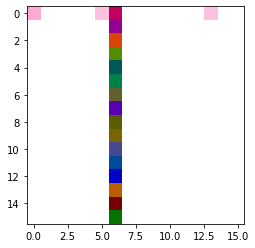

unit_time: 7.752334758639336
Unknown


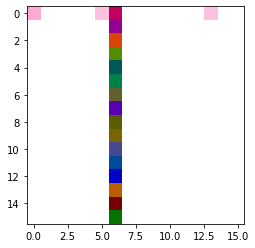

unit_time: 7.512174054980278
Unknown


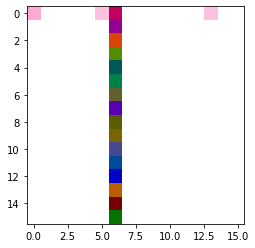

unit_time: 7.556053251028061
Unknown


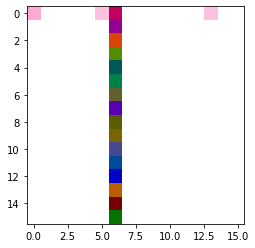

unit_time: 0.006828561425209045
Android


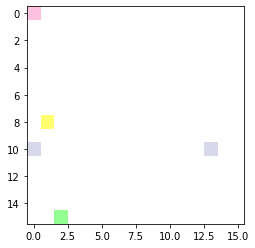

unit_time: 0.0014632493257522583
Android


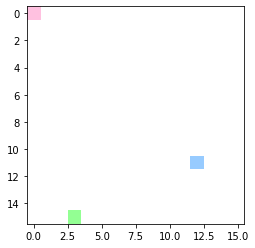

unit_time: 0.001542508602142334
Android


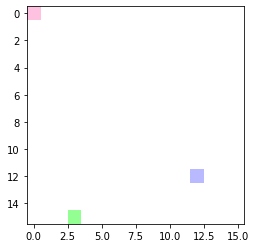

unit_time: 0.0009556859731674194
Android


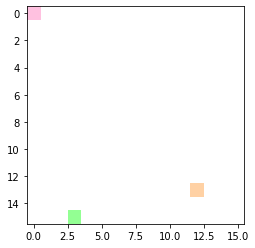

unit_time: 0.0007383078336715698
Android


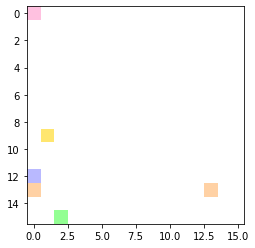

unit_time: 0.0006234347820281982
Android


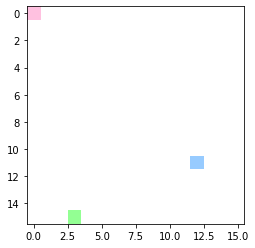

unit_time: 0.005691811442375183
Android


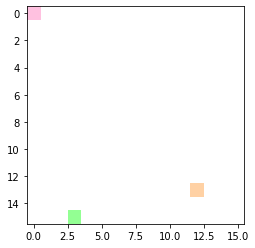

unit_time: 7.565739631652832
Unknown


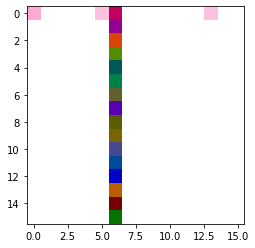

unit_time: 7.532976880669594
Unknown


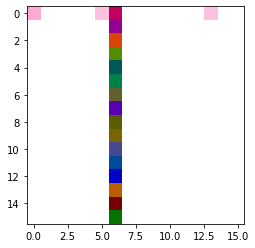

unit_time: 0.000525742769241333
Android


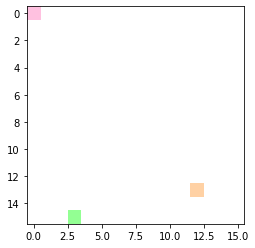

In [9]:
X = []
for file in files:
    counting_matrix, unit_time = extract_API_seqence_to_counting_matrix(file[:-4] + '.csv')
    img = making_image(counting_matrix)
    print(query_family(file[0:-4]))
    plt.imshow(img)
    plt.show()
    X.append(img)
X = np.array(X)

In [10]:
def target_encode(t):
    if t == "Unknown": return 0
    if t == "Mirai": return 1
    if t == "Android": return 2
Y = np.zeros(len(X))
for i in range(len(Y)):
    Y[i] = target_encode(all_category_count[i])

In [11]:
img_rows, img_cols = 16, 16
# the data, split between train and test sets
x_train = X
x_test = X
y_train = Y
y_test = Y

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('int')
y_test = y_test.astype('int')
x_train /= 255
x_test /= 255

In [19]:
base_model = create_base_model(input_shape)
head_model = create_head_model(base_model.output_shape)

siamese_network = SiameseNetwork(base_model, head_model)
siamese_network.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

siamese_checkpoint_path = "./siamese_checkpoint"

siamese_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=0),
    ModelCheckpoint(siamese_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=0)
]

few_shot_index = [np.where(y_train == i)[0][:5] for i in range(num_classes)]
few_shot_index = np.concatenate(few_shot_index, axis=None)
x_train_fewshot = x_train[few_shot_index]
y_train_fewshot = y_train[few_shot_index]
few_shot_index = [np.where(y_train == i)[0][5:] for i in range(num_classes)]
few_shot_index = np.concatenate(few_shot_index, axis=None)
x_test = x_train[few_shot_index]
y_test = y_train[few_shot_index]

siamese_network.fit(x_train_fewshot, y_train_fewshot,
                    validation_data=(x_train_fewshot[:500], y_train_fewshot[:500]),
                    batch_size=8,
                    epochs=10,
                    callbacks=siamese_callbacks)

C:\Users\cherry\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 2s 588ms/step - loss: 0.6621 - accuracy: 0.5625 - val_loss: 0.6964 - val_accuracy: 0.2500
INFO:tensorflow:Assets written to: .\siamese_checkpoint\assets
Epoch 2/10
1/1 [==============================] - 0s 82ms/step - loss: 0.8516 - accuracy: 0.4375 - val_loss: 0.6969 - val_accuracy: 0.5000
INFO:tensorflow:Assets written to: .\siamese_checkpoint\assets
Epoch 3/10
1/1 [==============================] - 0s 74ms/step - loss: 0.7032 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.8125
INFO:tensorflow:Assets written to: .\siamese_checkpoint\assets
Epoch 4/10
1/1 [==============================] - 0s 68ms/step - loss: 0.5833 - accuracy: 0.6875 - val_loss: 0.6855 - val_accuracy: 0.8125
Epoch 5/10
1/1 [==============================] - 0s 72ms/step - loss: 0.5603 - accuracy: 0.6875 - val_loss: 0.6786 - val_accuracy: 0.8750
INFO:tensorflow:Assets written to: .\siamese_checkpoint\assets
Epoch 6/10
1/1 [==============================] - 0s

In [20]:
for i in range(10):
    print(siamese_network.evaluate(x_test, y_test, batch_size=8))

[0.6616181135177612, 0.875]
[0.6568874716758728, 0.875]


C:\Users\cherry\anaconda3\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.6671690940856934, 0.8125]
[0.6626760959625244, 0.75]
[0.664542555809021, 0.8125]
[0.6647012233734131, 0.9375]
[0.6726974844932556, 0.625]
[0.6649696826934814, 0.9375]
[0.6681965589523315, 0.8125]
[0.672442615032196, 0.75]
